In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import linalg 
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix


## To do list
1. Load data.
2. Create the user-item interaction matrix $R$ using implicit feedback signals.

In [11]:
def parse_date(data):
    data['time'] = pd.to_datetime(data['time'], unit='s')
    return data


def read_data(path='', start_time='', end_time=''):
    _have = parse_date(pd.read_csv(path + '/' + 'have.csv', header=None, names=['user', 'item', 'time']))
    _wish = parse_date(pd.read_csv(path + '/' + 'wish.csv', header=None, names=['user', 'item', 'time']))
    _transact = parse_date(pd.read_csv(path + '/' + 'transac.csv', header=None, names=['giver', 'receiver', 'item', 'time']))
    
    pairs = pd.read_csv(path + '/' + 'pairs.csv', header=None, names=['user1', 'item1', 'user2', 'item2'])
    have = _have.loc[(start_time<_have['time'])&(_have['time']< end_time)]
    wish = _wish.loc[(start_time<_wish['time'])&(_wish['time']< end_time)]
    transact = _transact.loc[(start_time<_transact['time'])&(_transact['time']< end_time)]
    return have.sort_values(by=['user', 'time']).reset_index(drop=True), pairs, transact.sort_values(
        by=['time']).reset_index(drop=True), wish.sort_values(by=['user', 'time']).reset_index(drop=True)

def user_data(user, _have, _wish, _transact):
    # Return have and wish list for user.
    return _have.loc[_have['user'] == user], _wish.loc[_wish['user'] == user], _transact.loc[
        _transact['receiver'] == user]


def get_unique_users(_have, _transact, _wish):
    temp = np.concatenate \
        ((_have['user'].unique(), _transact['giver'].unique(), _transact['receiver'].unique(), _wish['user'].unique()))
    return np.unique(temp)


def get_unique_products(_have, _transact, _wish):
    temp = np.concatenate \
        ((_have['item'].unique(), _transact['item'].unique(), _wish['item'].unique()))
    return np.unique(temp)


def get_user_wish(user, _wish):
    return _wish.loc[_wish['user'] == user]['item'].values


def get_user_receive(user, _transact):
    return _transact.loc[_transact['receiver'] == user]['item'].values


def get_max_products_len(_wish, _transact):
    a = _wish.groupby('user')['item'].count().max()
    b = _transact.groupby('receiver')['item'].count().max()
    return max(a, b)


def get_coordinates(users_dict, products_dict, _data):
    row = np.array([])
    col = np.array([])

    if len(_data) != 0:
        if 'receiver' in _data.columns.values:
            _data = _data[['receiver', 'item']].values
        else:
            _data = _data[['user', 'item']].values
        row = np.array(list(map(users_dict.get, _data[:, 0])))
        col = np.array(list(map(products_dict.get, _data[:, 1])))

    return row, col


def gen_interaction_matrix(_data, _users_dict, _products_dict):
    """
    Create the user-item interaction matrix R.
    To create a sparse matrix.
    """
    _row, _col = get_coordinates(_users_dict, _products_dict, _data)
    return coo_matrix((np.ones(len(_row)), (_row, _col)), shape=(len(_users_dict), len(_products_dict)))



def slice_learning(_tensor, _rank, _users_dict, _products_dict):
    X = [gen_interaction_matrix(_dataset, _users_dict, _products_dict) for _dataset in _tensor]
    X1 = hstack(X)
    X2 = hstack([_slice.transpose() for _slice in X])
    U, temp_S, temp_V = linalg.svds(X1, k=_rank)
    temp_U, temp, V = linalg.svds(X2, k=_rank)
    M_tensor = [U @ U.transpose() @ _slice @ V @ V.transpose() for _slice in X]
    return M_tensor

In [10]:
have.loc[('2014-09-05'<have['time'])&(have['time']<'2014-09-08')]

,user,item,time
0,304,1885497,2014-09-05 11:51:27
1,304,1885510,2014-09-05 12:09:46
2,304,1885502,2014-09-05 12:21:11
7,665,1886858,2014-09-07 10:54:11
13,1539,1261301,2014-09-05 01:30:25
...,...,...,...
2210,84827,2006670,2014-09-06 08:09:31
2211,84827,2006673,2014-09-06 08:33:44
2212,84827,2006674,2014-09-06 09:32:28
2213,84827,2006672,2014-09-06 09:51:36


In [12]:
have, pairs, transact, wish = read_data('./bm1y', '2014-09-03','2014-9-15')

# temp = (wish_.groupby('user').count()['item']<3000)
# limit_index = temp.loc[temp==True].index
# wish = wish_.loc[np.isin(wish_['user'],limit_index)]

users = get_unique_users(have, transact, wish)
products = get_unique_products(have, transact, wish)

users_dict = {}
for index,value in zip(range(len(users)),users):
    users_dict[value]=index

products_dict = {}
for index,value in zip(range(len(products)),products):
    products_dict[value]=index

# Data process

In [9]:
X = [gen_interaction_matrix(data,users_dict, products_dict) for data in [wish,have]]
X1 = hstack(X)
X2 = hstack([_slice.transpose() for _slice in X])

In [10]:
U1, S1, V1 = linalg.svds(X1, k=3)
U2, S2, V2 = linalg.svds(X2, k=3)
P_users = U1 @ U1.transpose()
P_products = U2 @ U2.transpose()

KeyboardInterrupt: 

In [36]:
A = np.random.random((4,4))
B = np.random.random((4,4))

In [37]:
A

array([[0.86207057, 0.91290554, 0.46606913, 0.82574448],
       [0.15368381, 0.63691059, 0.3428837 , 0.31176107],
       [0.03896312, 0.42669025, 0.50771547, 0.15118214],
       [0.16743321, 0.703061  , 0.00847324, 0.64017121]])

In [39]:
np.where(A>0.5,1,0)

array([[1, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 1]])

In [41]:
confusion_matrix(np.where(A>0.5,1,0).flatten(),np.where(B>0.5,1,0).flatten()).ravel()

array([3, 6, 3, 4])

In [ ]:
M = P_users @ X[0] @ P_products

In [11]:
print(U1.shape,V1.shape)
print(U2.shape,V2.shape)
print(P_users.shape)
print(P_products.shape)

(4037, 3) (3, 42322)
(21161, 3) (3, 8074)
(4037, 4037)
(42429, 42429)


# Plot

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

## Daily trading volume.

In [ ]:
day_trade = transac.groupby(transac['time'].dt.date).count()['time']
ax = sns.kdeplot(day_trade,bw_adjust=1,cut=0,cumulative=False)
ax.set(xlabel='times')
# ax.get_figure().savefig('trade PDF.png')
plt.show()

Text(0, 0.5, 'Trading Volume')

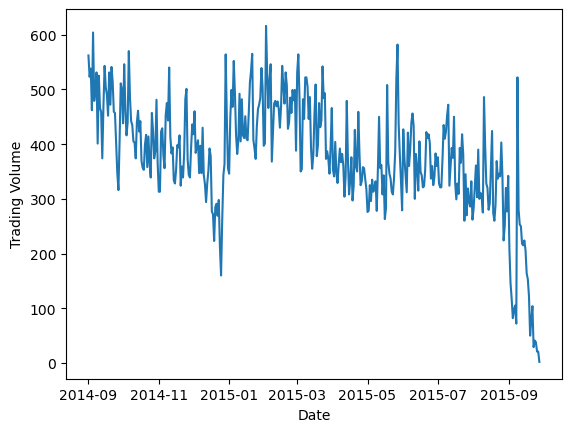

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(day_trade)
ax.set_xlabel('Date')
ax.set_ylabel('Trading Volume')
# fig.savefig('trading.png',dpi=200)

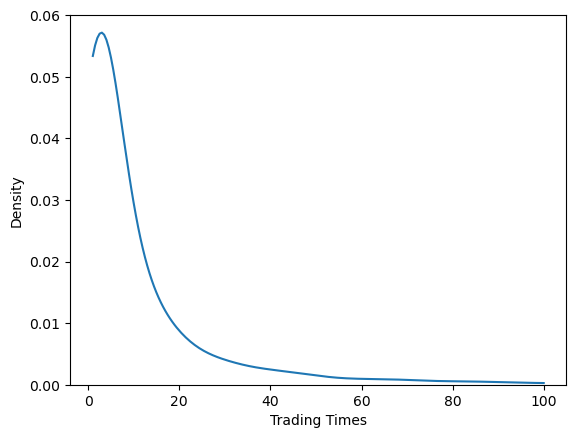

In [17]:
give = transac.groupby(transac['giver']).count()['item']
ax = sns.kdeplot(give,bw_adjust=1,cumulative=False,clip= (1, 100.0))
ax.set(xlabel='Trading Times')
ax.get_figure().savefig('trade PDF.png',dpi=200)
# plt.show()